# Merge and Preprocess Data

In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets
customer_transactions = pd.merge(transactions, customers, on="CustomerID")

# Aggregate features for clustering
customer_features = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',                      # Total spend
    'Quantity': 'sum',                        # Total quantity purchased
    'TransactionID': 'count',                 # Number of transactions
    'Region': 'first',                        # Region from customer profile
}).reset_index()

# Rename TransactionID to NumTransactions
customer_features.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_cols = ['TotalValue', 'Quantity', 'NumTransactions']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# One-hot encode the categorical feature 'Region'
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Display processed features
print(customer_features.head())


  CustomerID  TotalValue  Quantity  NumTransactions  Region_Asia  \
0      C0001    0.308942  0.354839              0.4        False   
1      C0002    0.168095  0.290323              0.3         True   
2      C0003    0.249541  0.419355              0.3        False   
3      C0004    0.497806  0.709677              0.7        False   
4      C0005    0.184287  0.193548              0.2         True   

   Region_Europe  Region_North America  Region_South America  
0          False                 False                  True  
1          False                 False                 False  
2          False                 False                  True  
3          False                 False                  True  
4          False                 False                 False  


# Perform Clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Extract feature matrix for clustering
feature_matrix = customer_features.drop('CustomerID', axis=1)

# Try different numbers of clusters (2 to 10) and calculate DB Index
cluster_metrics = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)
    db_index = davies_bouldin_score(feature_matrix, labels)
    cluster_metrics.append((k, db_index))

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = min(cluster_metrics, key=lambda x: x[1])
print(f"Optimal Number of Clusters: {optimal_clusters[0]}, DB Index: {optimal_clusters[1]}")

# Final model with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters[0], random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(feature_matrix)


Optimal Number of Clusters: 4, DB Index: 0.4312542115430423


# Visualize Clusters

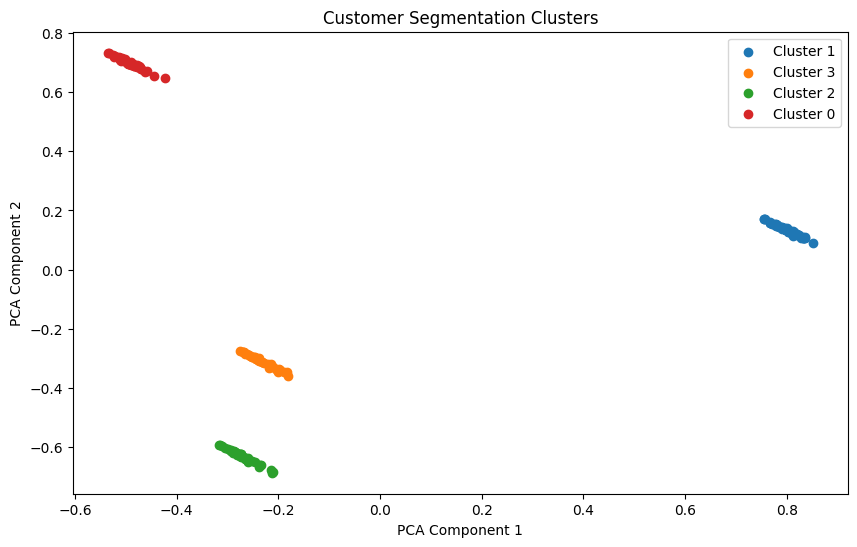

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)
reduced_df = pd.DataFrame(reduced_features, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = customer_features['Cluster']

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in reduced_df['Cluster'].unique():
    cluster_data = reduced_df[reduced_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


# Report Metrics

In [4]:
# Print cluster centers (if using K-Means)
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Save clusters to a CSV for further analysis
customer_features.to_csv("Customer_Segments.csv", index=False)
print("Clustering results saved to 'Customer_Segments.csv'")


Cluster Centers:
[[3.06163389e-01 3.51612903e-01 3.68000000e-01 1.94289029e-16
  1.00000000e+00 8.32667268e-17 0.00000000e+00]
 [3.43244731e-01 3.99125205e-01 4.15254237e-01 2.49800181e-16
  3.88578059e-16 1.66533454e-16 1.00000000e+00]
 [3.04848022e-01 3.83590463e-01 4.30434783e-01 1.94289029e-16
  2.77555756e-16 1.00000000e+00 0.00000000e+00]
 [3.18546583e-01 3.78299120e-01 3.95454545e-01 1.00000000e+00
  2.22044605e-16 2.77555756e-17 0.00000000e+00]]
Clustering results saved to 'Customer_Segments.csv'


# Load Data

In [5]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
